In [1]:
import sys

sys.path.insert(0, "/home/esrf/james1997a/Code/ImageD11")

In [ ]:
import fabio
from tqdm.autonotebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

from segmentation import load_test_image, LocalBGCorrector

%matplotlib ipympl

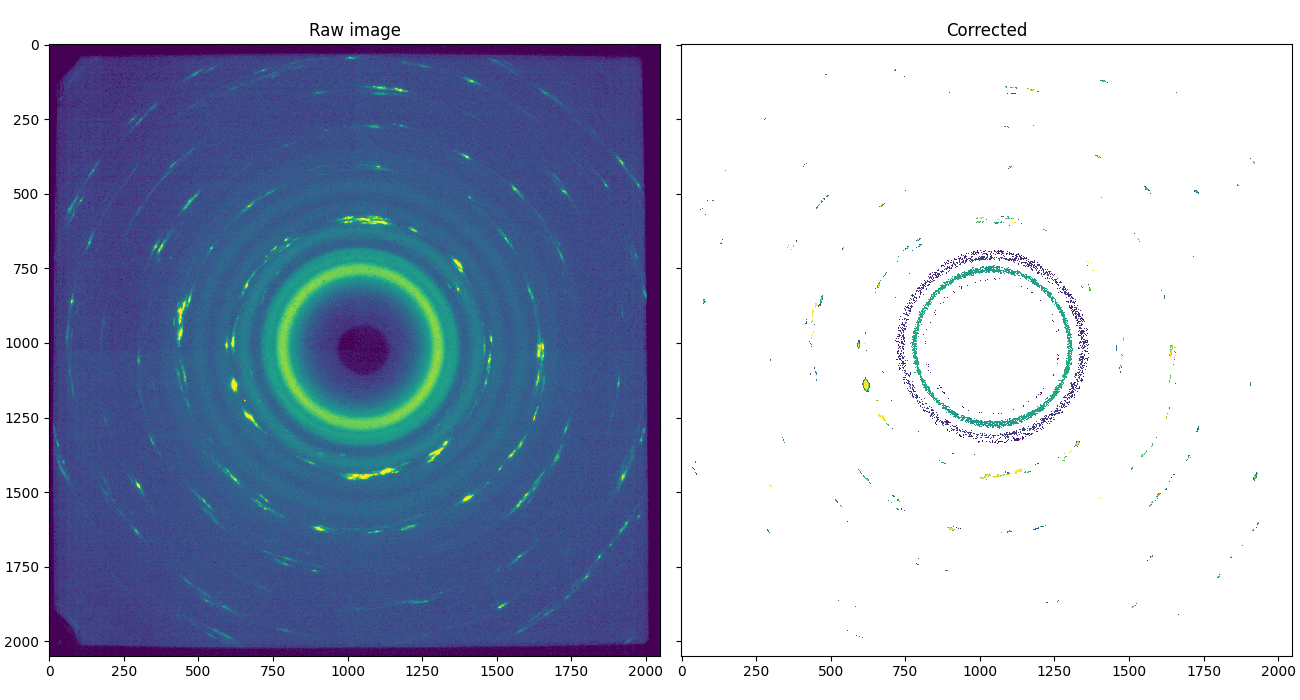

In [3]:
image = load_test_image(
    "/data/visitor/es1416/id11/20240430/RAW_DATA/NaCl52_water/NaCl52_water_FF_0/NaCl52_water_FF_0.h5"
).astype(np.float32)
mask = fabio.open(
    "/data/visitor/es1416/id11/20240430/SCRIPTS/james_ball/2025/S3DXRD/frelon_mask.edf"
).data.astype(bool)
bg = fabio.open(
    "/data/visitor/es1416/id11/20240430/SCRIPTS/james_ball/2025/S3DXRD/frelon_background_es1416.edf"
).data.astype(np.float32)
flat = fabio.open(
    "/data/visitor/es1416/id11/20240430/SCRIPTS/james_ball/2025/S3DXRD/F36_Nov2023.edf"
).data.astype(np.float32)
dark = fabio.open(
    "/data/visitor/es1416/id11/20240430/SCRIPTS/james_ball/2025/S3DXRD/dark_20240416.edf"
).data.astype(np.float32)

corrfunc = LocalBGCorrector(threshold=100,
                            smoothsigma=1.0,
                            bgc=0.9,
                            bg=bg,
                            dark=dark,
                            flat=flat,
                            mask=mask,
                            m_offset_thresh=70,
                            m_ratio_thresh=150)

corrected = corrfunc(image)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(13, 7))
axs[0].imshow(image, norm="log", vmin=100, vmax=1000, interpolation="nearest")
axs[1].imshow(corrected, norm='log', vmin=100, vmax=1000, interpolation="nearest")
axs[0].set_title('Raw image')
axs[1].set_title('Corrected')
plt.show()

In [4]:
import ImageD11.cImageD11

In [5]:
labels = np.empty(image.shape, dtype="i")
wrk = np.empty(image.shape, dtype="b")
npks = ImageD11.cImageD11.localmaxlabel(corrected, labels, wrk)

In [6]:
blobs = ImageD11.cImageD11.blobproperties(
    corrected, labels * (corrected > 0), npks, omega=0.0
)
ImageD11.cImageD11.blob_moments(blobs)
enoughpx = blobs[:, ImageD11.cImageD11.s_1] >= 3
goodpeaks = blobs[enoughpx]


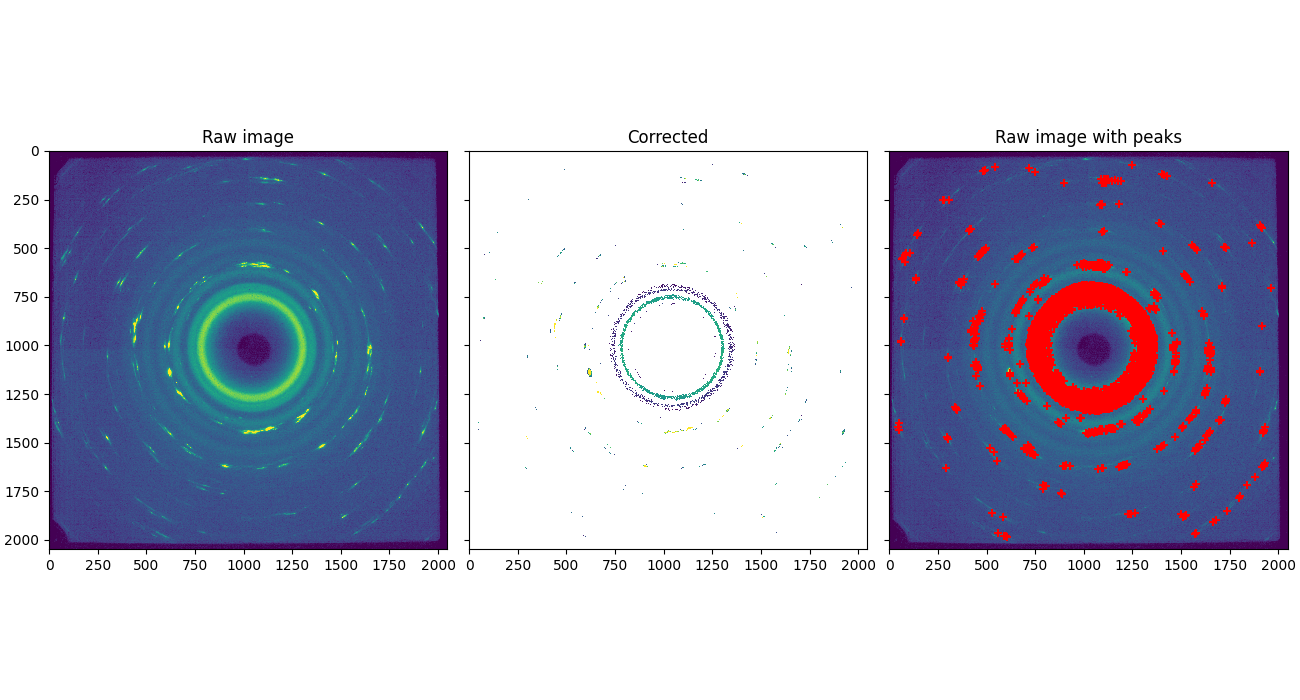

In [7]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True, figsize=(13, 7))
axs[0].imshow(image, norm="log", vmin=100, vmax=1000, interpolation="nearest")
axs[1].imshow(corrected, norm='log', vmin=100, vmax=1000, interpolation="nearest")
axs[2].imshow(image, norm="log", vmin=100, vmax=1000, interpolation="nearest")
fc, sc = goodpeaks[:, 23:25].T
axs[2].scatter(fc, sc, c='red', marker='+')
axs[0].set_title('Raw image')
axs[1].set_title('Corrected')
axs[2].set_title('Raw image with peaks')
plt.show()